In [2]:
from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import pandas as pd

In [3]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool
from spektral.layers.pooling import TopKPool
from spektral.transforms.normalize_adj import NormalizeAdj
import pickle as pkl
import networkx as nx
import pdb
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load circuit graph, features and labels
- Load pickle and initialize dataset with graph adjacency matrix, 4 node features and 1 label.
- Add self loop edge to retain the node properties
- Use disjoint mode with node level true settings to load all the circuits as one big graph.
- Normalize features
- Split dataset into training, validation and test.


In [378]:
################################################################################
# PARAMETERS
################################################################################
batch_size = 1  # Batch size


################################################################################
# LOAD DATA
################################################################################
import sys
from spektral.data import Dataset, Graph
# sys.path.append('../lib')
# from data_pre_processing import load_data
# sys.path.remove('../lib')
from spektral.layers import GCNConv
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess, NormalizeOne

def load_data(circuit_name, path_to_data="data", normalize=False):
    """Load data."""
    names = ["x", "y", "graph"]
    objects = []
    for i in range(len(names)):
        with open(f"{path_to_data}/{circuit_name}.{names[i]}", "rb") as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding="latin1"))
            else:
                objects.append(pkl.load(f))

    x, y, graph = tuple(objects)
    
    features = _preprocess_features(sp.csr_matrix(x).astype('float32'))
    # adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph)).astype(int)
    g = nx.DiGraph()
    g.add_nodes_from(graph.keys())
    for k, v in graph.items():
      g.add_edges_from(([(k, t) for t in v]))
      g.add_edges_from([(k, k)])
    adj = nx.adjacency_matrix(g)
    labels = np.array(y).astype('float32').reshape((-1,1))

    print(adj.shape)
    print(features.shape)
    return adj, features, labels
  
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels

def _preprocess_features(features):
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features


class CircuitDataset(Dataset):
    def read(self):
        circuits = []
        circs = ['c6288','c5315', 'c1355', 'c1908', 'c3540', 'adder.bench', 'arbiter.bench', 'cavlc.bench', 'dec.bench']
#         circs = ['c6288','c5315', 'c432', 'c499', 'c880', 'c1355', 'c1908', 'c3540']
        for circ in circs:
            A, X, labels = load_data(circ, '../data/output', normalize="")
            circuits.append(Graph(x=X.toarray(), a=A, y=labels))
            print(f"{circ}: {sum(labels)}, {len(labels)}")
        return circuits

# dataset = CircuitDataset(transforms=[LayerPreprocess(GCNConv), NormalizeOne()])

dataset = CircuitDataset(transforms=[LayerPreprocess(GCNConv)])
# Parameters
F = dataset.n_node_features  # Dimension of node features
n_out = dataset.n_labels  # Dimension of the target

# Train/valid/test split
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
print(idx_tr, idx_va, idx_te)
# [8 6 5 0 1 4 2] [3] [7]
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]
# dataset_tr = dataset[[8,6,5,1,2, 0, 3, 4, 7]]
# dataset_va = dataset[[0,3]]
# dataset_te = dataset[4,7]
# loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
# loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
# loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
def load_tr_data(epochs=400):
    loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
    loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
    loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
    return loader_tr, loader_va, loader_te

loader_tr, loader_va, loader_te = load_tr_data()


(6288, 6288)
(6288, 4)
c6288: [846.], 6288
(5315, 5315)
(5315, 4)
c5315: [599.], 5315
(1355, 1355)
(1355, 4)
c1355: [192.], 1355
(1908, 1908)
(1908, 4)
c1908: [257.], 1908
(3540, 3540)
(3540, 4)
c3540: [406.], 3540
(4209, 4209)
(4209, 4)
adder.bench: [637.], 4209
(36352, 36352)
(36352, 4)
arbiter.bench: [3763.], 36352
(2164, 2164)
(2164, 4)
cavlc.bench: [318.], 2164
(936, 936)
(936, 4)
dec.bench: [186.], 936
[6 1 2 3 5 4 8] [7] [0]


In [379]:
N = sum([ g.n_nodes for g in dataset.graphs ])
n_out = 1
N

62067

# Multilayer GCN model
- Focal loss for unbalanced dataset
- Increased channels
- 3 LAYERS

In [510]:
channels = 256         # Number of channels in the first layer
dropout = 0.05         # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 100           # Number of training epochs
es_patience = 10        # Patience for early stopping
# N = 

# Model definition
X_in = Input(shape=(F, ))
print("X_in: ", X_in.shape)
fltr_in = Input((None, ), sparse=True)
# mask_in = Input((None, ))

x_1 = BatchNormalization()(X_in)
dropout_1 = Dropout(dropout)(x_1 )
graph_conv_1 = GCNConv(2048,
                         activation='relu',
#                          kernel_regularizer=l2(l2_reg),
                         use_bias=True)([dropout_1, fltr_in])
x_2 = BatchNormalization()(graph_conv_1)
dropout_2 = Dropout(dropout)(graph_conv_1)
# dropout_2 = Dropout(dropout)(X_in)
graph_conv_2 = GCNConv(256,
                         activation='relu',
#                          kernel_regularizer=l2(l2_reg),
                         use_bias=True)([dropout_2, fltr_in])
x_3 = BatchNormalization()(graph_conv_2)
dropout_3 = Dropout(dropout)(graph_conv_2)
graph_conv_3 = GCNConv(16,
                         activation='relu',
#                          kernel_regularizer=l2(l2_reg),
                         use_bias=True)([dropout_3, fltr_in])
x_4 = BatchNormalization()(graph_conv_3)
dropout_4 = Dropout(dropout)(x_4)
graph_conv_4 = GCNConv(n_out,
                         activation='sigmoid',
#                          kernel_regularizer=l2(l2_reg),
                         use_bias=True)([dropout_4, fltr_in])

model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_4)
optimizer = Adam(lr=learning_rate)
# model.compile(optimizer=optimizer,
#               loss='categorical_crossentropy',
#               weighted_metrics=['acc'])

# x_in = Input(shape=(F,))
# a_in = Input((None, ), sparse=True)
# x_1 = GCNConv(channels, activation="relu")([x_in, a_in])
# x_1 = BatchNormalization()(x_1)
# x_1 = Dropout(dropout)(x_1)
# x_2 = GCNConv(channels, activation="relu")([x_1, a_in])
# x_2 = BatchNormalization()(x_2)
# x_2 = Dropout(dropout)(x_2)
# x_3 = GCNConv(n_out, activation="sigmoid")([x_2, a_in])

import tensorflow.keras.backend as K
def focal_loss(y_true, y_pred, gamma=2, alpha=0.25):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


model.compile(optimizer=optimizer,
              loss=focal_loss,
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./DetectFaultInCircuit',
)
callback_GCN = [tbCallBack_GCN]

X_in:  (None, 4)
Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_79 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
dropout_129 (Dropout)           (None, 4)            0           input_79[0][0]                   
__________________________________________________________________________________________________
input_80 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
gcn_conv_129 (GCNConv)          (None, 2048)         10240       dropout_129[0][0]                
                                                                 input_80[

In [500]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy, binary_accuracy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.layers import GCNConv, GlobalSumPool
from spektral.layers.ops import sp_matrix_to_sp_tensor
from sklearn.utils.class_weight import compute_class_weight


# Train Model
- Use batch loader to train the model else it fails due to huge memory usage
- Class Balancing is done by computing Weight based on class.

In [501]:
!pip install focal-loss

In [519]:
optimizer = Adam()
# loss_fn = SparseCategoricalCrossentropy()
# loss_fn = BinaryCrossentropy()
loss_fn = binary_crossentropy
loader_tr, loader_va, loader_te = load_tr_data(epochs)
from focal_loss import BinaryFocalLoss
focal_loss_fn = BinaryFocalLoss(gamma=0.9999, pos_weight=0.9)
# def input_mask(target):
#     minimum = tf.math.minimum(tf.reduce_sum(tf.dtypes.cast(target == 0, tf.int32)), tf.reduce_sum(tf.dtypes.cast(target == 1, tf.int32)))
#     zeroes_index = tf.random.shuffle(tf.where(target == 0)[:,0])[:minimum]
#     ones_index = tf.random.shuffle(tf.where(target == 1)[:,0])[:minimum]
    
#     stacked_inp = tf.reshape(tf.stack([zeroes_index, ones_index]), (-1,1))
#     zeros_stack = tf.reshape(tf.stack([stacked_inp, tf.zeros((minimum*2,1), dtype='int64')], axis=1), (-1,2))
#     sparsed_data = tf.SparseTensor(zeros_stack, tf.ones((minimum*2, )), target.shape)
#     return tf.sparse.to_dense(tf.sparse.reorder(sparsed_data), default_value = 0. )

def masked_loss_and_accuracy(target, predictions):
#     values_keep = tf.gather( logits[0], idx_keep )
    loss = loss_fn(target, predictions)
    minimum = tf.math.minimum(tf.reduce_sum(tf.dtypes.cast(target == 0, tf.int32)), tf.reduce_sum(tf.dtypes.cast(target == 1, tf.int32)))
    zeroes_index = tf.random.shuffle(tf.where(target == 0)[:,0])
    ones_index = tf.random.shuffle(tf.where(target == 1)[:,0])
    loss_zeroes =  tf.reduce_mean(tf.gather(loss, zeroes_index))
    loss_ones = tf.reduce_mean(tf.gather(loss, ones_index))
    
    weight_for_0 = tf.cast((1 / tf.shape(zeroes_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')
    weight_for_1 = tf.cast((1 / tf.shape(ones_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')

#     pdb.set_trace()
    loss = (weight_for_0 * loss_zeroes * 0.6 +  weight_for_1 * loss_ones * 0.4)
    loss = focal_loss_fn(target, predictions)
#     loss = tf.reduce_mean(tf.multiply(loss, mask))
    bin_acc = binary_accuracy(target, predictions)
    acc = tf.reduce_mean(bin_acc)
    return loss, acc

# Training function
@tf.function
def train_on_batch(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs[:-1], training=True)
        loss, acc = masked_loss_and_accuracy(target, predictions)
        loss = loss + sum(model.losses)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc


# Evaluation function
def evaluate(loader):
    step = 0
    results = []
    for batch in loader:
        step += 1
        inputs, target = batch
        predictions = model(inputs[:-1], training=False)
        loss, acc = masked_loss_and_accuracy(target, predictions)
        results.append((loss, acc, len(target)))  # Keep track of batch size
        if step == loader.steps_per_epoch:
            results = np.array(results)
            return np.average(results[:, :-1], 0, weights=results[:, -1])

patience = 10
# Setup training
best_val_loss = 99999
current_patience = patience
step = 0

# Training loop
results_tr = []
history = []
for current_epoch, batch in enumerate(loader_tr):
    step += 1

    # Training step
    inputs, target = batch
    loss, acc = train_on_batch(inputs, target)
    results_tr.append((loss, acc, len(target)))
    if step == loader_tr.steps_per_epoch:
        results_va = evaluate(loader_va)
        if results_va[0] < best_val_loss:
            best_val_loss = results_va[0]
            current_patience = patience
            results_te = evaluate(loader_te)
        else:
            current_patience -= 1
#             if current_patience == 0:
#                 print("Early stopping")
#                 break

        # Print results
        results_tr = np.array(results_tr)
        results_tr = np.average(results_tr[:, :-1], 0, weights=results_tr[:, -1])
        print(
            "Epoch: {:3d} | "
            "Train loss: {:.4f}, acc: {:.4f} | "
            "Valid loss: {:.4f}, acc: {:.4f} | "
            "Test loss: {:.4f}, acc: {:.4f}".format(
                current_epoch, *results_tr, *results_va, *results_te
            )
        )
        history.append([results_tr[0], results_va[0]])
        # Reset epoch
        results_tr = []
        step = 0
        
print("Training Completed!!!!")

Epoch:   6 | Train loss: 0.1203, acc: 0.9154 | Valid loss: 0.2495, acc: 0.7911 | Test loss: 0.2137, acc: 0.8357
Epoch:  13 | Train loss: 0.1116, acc: 0.9286 | Valid loss: 0.1955, acc: 0.8526 | Test loss: 0.2079, acc: 0.8655
Epoch:  20 | Train loss: 0.1514, acc: 0.8895 | Valid loss: 0.1936, acc: 0.8530 | Test loss: 0.2091, acc: 0.8655
Epoch:  27 | Train loss: 0.1080, acc: 0.9289 | Valid loss: 0.2751, acc: 0.8530 | Test loss: 0.2091, acc: 0.8655
Epoch:  34 | Train loss: 0.1049, acc: 0.9310 | Valid loss: 0.3199, acc: 0.8392 | Test loss: 0.2091, acc: 0.8655
Epoch:  41 | Train loss: 0.1018, acc: 0.9328 | Valid loss: 0.2259, acc: 0.8383 | Test loss: 0.2091, acc: 0.8655
Epoch:  48 | Train loss: 0.1015, acc: 0.9331 | Valid loss: 0.2565, acc: 0.8115 | Test loss: 0.2091, acc: 0.8655
Epoch:  55 | Train loss: 0.0988, acc: 0.9348 | Valid loss: 0.2496, acc: 0.8110 | Test loss: 0.2091, acc: 0.8655
Epoch:  62 | Train loss: 0.0950, acc: 0.9366 | Valid loss: 0.2790, acc: 0.8161 | Test loss: 0.2091, acc:

Epoch: 391 | Train loss: 0.0887, acc: 0.9426 | Valid loss: 0.4881, acc: 0.7375 | Test loss: 0.2091, acc: 0.8655
Epoch: 398 | Train loss: 0.0916, acc: 0.9317 | Valid loss: 0.4835, acc: 0.7468 | Test loss: 0.2091, acc: 0.8655
Epoch: 405 | Train loss: 0.0867, acc: 0.9375 | Valid loss: 0.3964, acc: 0.7135 | Test loss: 0.2091, acc: 0.8655
Epoch: 412 | Train loss: 0.0826, acc: 0.9412 | Valid loss: 0.3739, acc: 0.6530 | Test loss: 0.2091, acc: 0.8655
Epoch: 419 | Train loss: 0.0812, acc: 0.9425 | Valid loss: 0.3648, acc: 0.6890 | Test loss: 0.2091, acc: 0.8655
Epoch: 426 | Train loss: 0.0831, acc: 0.9372 | Valid loss: 0.3622, acc: 0.6446 | Test loss: 0.2091, acc: 0.8655
Epoch: 433 | Train loss: 0.0842, acc: 0.9411 | Valid loss: 0.3856, acc: 0.7274 | Test loss: 0.2091, acc: 0.8655
Epoch: 440 | Train loss: 0.0868, acc: 0.9374 | Valid loss: 0.4169, acc: 0.7454 | Test loss: 0.2091, acc: 0.8655
Epoch: 447 | Train loss: 0.0895, acc: 0.9367 | Valid loss: 0.3971, acc: 0.7634 | Test loss: 0.2091, acc:

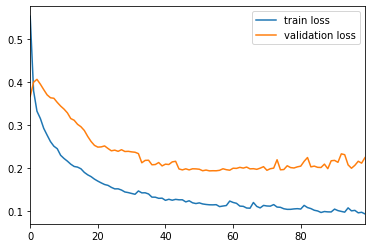

In [512]:
# loss_history = list(map(lambda x: x.numpy(), history))
# # loss_history
df = pd.DataFrame(history, columns=['train loss', 'validation loss'])
df.plot()

In [513]:
# Evaluate model
from sklearn.metrics import classification_report

X_te = dataset[4].x
A_te = dataset[4].a
y_te = dataset[4].y

y_pred = model.predict([X_te, A_te], batch_size=X_te.shape[0])
report = classification_report(y_te, (y_pred >= 0.5).astype(int))
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      3134
         1.0       0.88      0.14      0.24       406

    accuracy                           0.90      3540
   macro avg       0.89      0.57      0.59      3540
weighted avg       0.90      0.90      0.86      3540



In [514]:
(y_pred >= 0.5).astype(int).sum()
# y_te[59]

64

# Classification Report

In [515]:
from sklearn.metrics import classification_report

X_te = dataset[7].x
A_te = dataset[7].a
y_te = dataset[7].y

y_pred = model.predict([X_te, A_te], batch_size=X_te.shape[0])
report = classification_report(y_te, (y_pred >= 0.5).astype(int))
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.85      0.95      0.90      1846
         1.0       0.06      0.02      0.02       318

    accuracy                           0.82      2164
   macro avg       0.45      0.49      0.46      2164
weighted avg       0.73      0.82      0.77      2164



In [516]:
(y_pred >= 0.5).astype(int).sum()

89

In [517]:
from sklearn.metrics import classification_report

X_te = dataset[0].x
A_te = dataset[0].a
y_te = dataset[0].y

y_pred = model.predict([X_te, A_te], batch_size=X_te.shape[0])
report = classification_report(y_te, (y_pred >= 0.5).astype(int))
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      5442
         1.0       0.00      0.00      0.00       846

    accuracy                           0.87      6288
   macro avg       0.43      0.50      0.46      6288
weighted avg       0.75      0.87      0.80      6288



/Users/nikitaacharya/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [518]:
(y_pred >= 0.5).astype(int).sum()

0

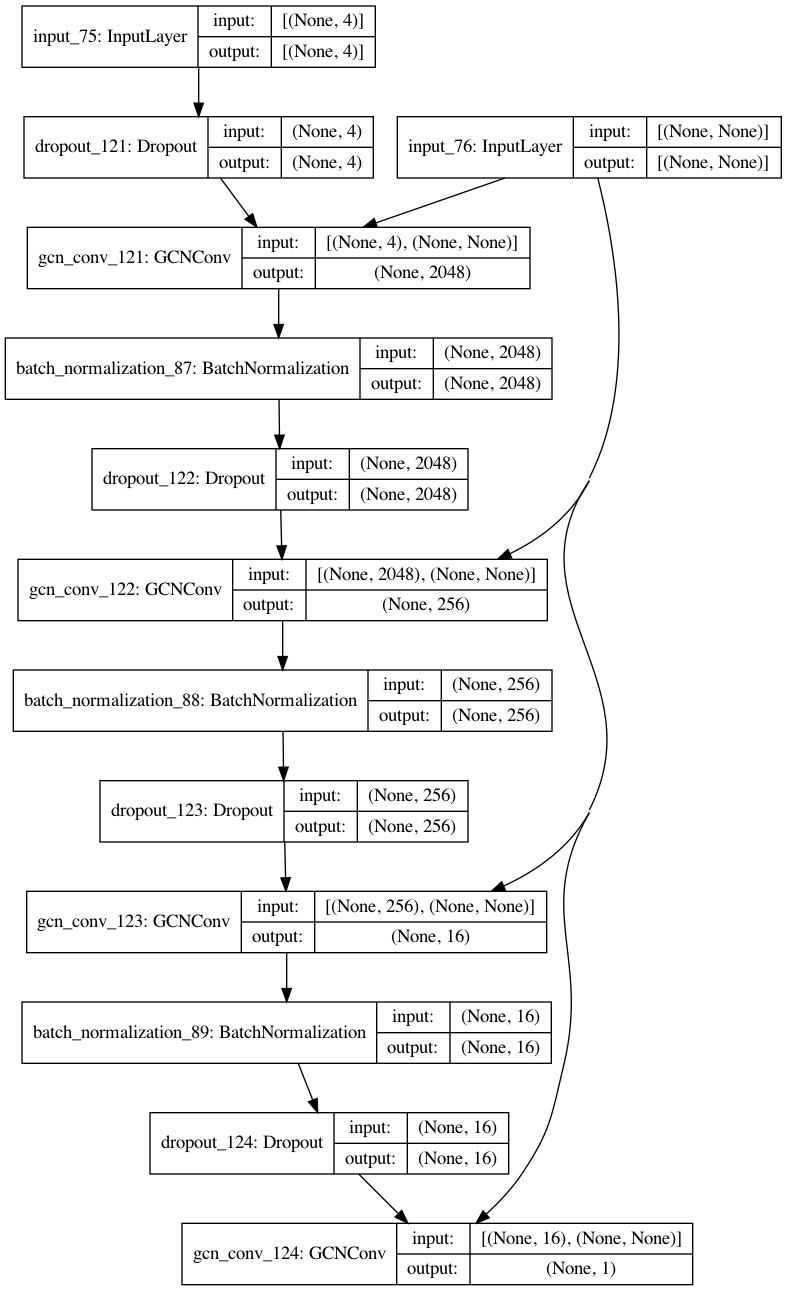

In [496]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

#  Fully-Connected Neural Networks 

## Building and Training FNN


In [ ]:
optimizer = Adam(lr=1e-2)
l2_reg = 5e-4
epochs = 200

#Compare with FNN
#Construct the model
model_fnn = Sequential()
model_fnn.add(Dense(
                    256,
                    input_dim=X.shape[1],
                    activation=tf.nn.relu,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
             )
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation=tf.nn.relu))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(num_classes, activation=tf.keras.activations.sigmoid))


model_fnn.compile(optimizer=optimizer,
              loss=focal_loss,
              weighted_metrics=['acc'])


#define TensorBoard
tbCallBack_FNN = TensorBoard(
    log_dir='./fnn_network',
)

#Train model
validation_data_fnn = (X, labels_encoded, val_mask)
model_fnn.fit(
                X,labels_encoded,
                sample_weight=train_mask,
                epochs=epochs,
                batch_size=N,
                validation_data=validation_data_fnn,
                shuffle=False,
                callbacks=[
                  EarlyStopping(patience=es_patience,  restore_best_weights=True),
                  tbCallBack_FNN
          ])

In [ ]:
from sklearn.metrics import classification_report

X_te = dataset[3].x
A_te = dataset[3].a
y_te = dataset[3].y

y_pred = model_fnn.predict(X_te)
report = classification_report(y_te, (y_pred >= 0.5).astype(int))
print('FCNN Classification Report: \n {}'.format(report))